# **Importing Libraries**

In [19]:
#Importing libraries
import tensorflow as tf
import keras
from keras.models import Model
from keras.layers import Dense,Input
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import load_model
from sklearn.metrics import confusion_matrix
from keras.layers import GaussianNoise


# **Input Data**

In [7]:
#Input Data 
(X_train,Y_train),(X_test,Y_test) = mnist.load_data()

#Data Preprocessing
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
#Reshaping model size (n,784) 
X_train = X_train.reshape( len(X_train) ,np.prod(X_train.shape[1:]))
X_test = X_test.reshape(len(X_test),np.prod(X_test.shape[1:] ))


# **Autoencoder Model**

In [113]:
#Creating Autoencoder model
val = 64
img = Input(shape=(784,) )
encoded = Dense(val, activation = 'relu')(img)
decoded = Dense(784, activation = 'sigmoid')(encoded)

autoencoder = Model(img,decoded)

encoder = Model(img,encoded)

encoded_val= Input(shape= (val,))

decoder_layer = autoencoder.layers[-1]

decoder = Model(encoded_val, decoder_layer(encoded_val))
#compiling the model
autoencoder.compile(optimizer= 'adam', loss = 'mse', )

checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    
    save_best_only=True)

#fitting data into model
#1) Original data
autoencoder.fit(X_train, X_train, batch_size=32, epochs = 100, validation_data= (X_test,X_test),callbacks=[model_checkpoint_callback] )
autoencoder.summary()

encoded_images= encoder.predict(X_test)
decoded_images = decoder.predict(encoded_images)


Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 6s 95us/step - loss: 0.0242 - val_loss: 0.0093
Epoch 2/100
60000/60000 [==============================] - 6s 94us/step - loss: 0.0070 - val_loss: 0.0054
Epoch 3/100
60000/60000 [==============================] - 6s 95us/step - loss: 0.0051 - val_loss: 0.0046
Epoch 4/100
60000/60000 [==============================] - 6s 93us/step - loss: 0.0046 - val_loss: 0.0043
Epoch 5/100
60000/60000 [==============================] - 6s 94us/step - loss: 0.0044 - val_loss: 0.0041
Epoch 6/100
60000/60000 [==============================] - 6s 95us/step - loss: 0.0042 - val_loss: 0.0041
Epoch 7/100
60000/60000 [==============================] - 6s 98us/step - loss: 0.0041 - val_loss: 0.0040
Epoch 8/100
60000/60000 [==============================] - 6s 104us/step - loss: 0.0041 - val_loss: 0.0039
Epoch 9/100
60000/60000 [==============================] - 6s 95us/step - loss: 0.0040 - val_loss: 0.

# **Addition of Gaussian Noise under DP std=0.1 and results**

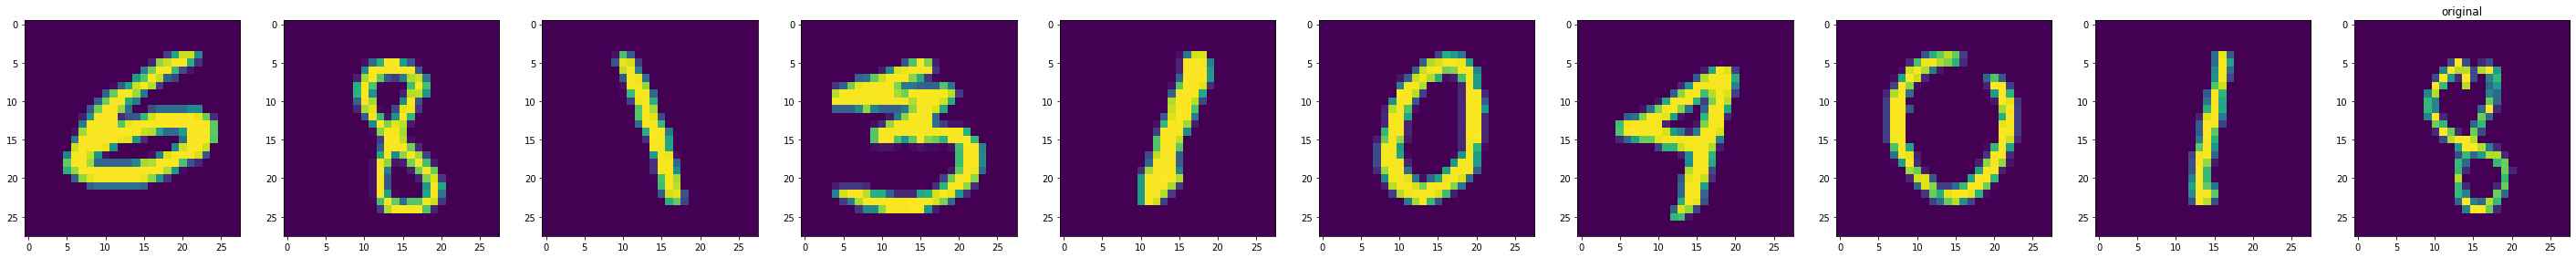

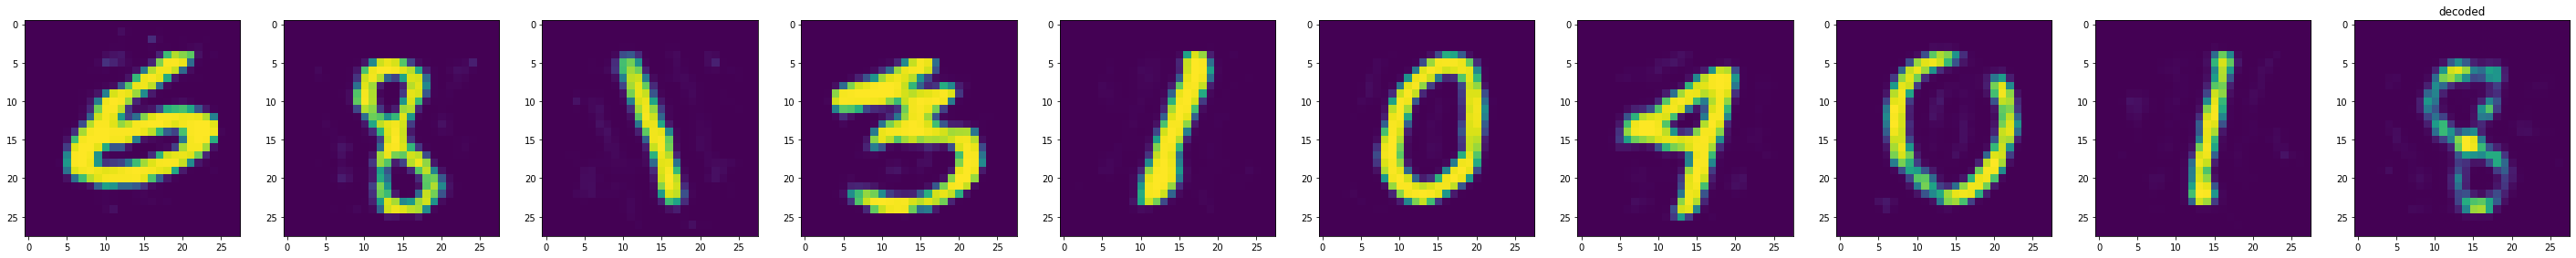

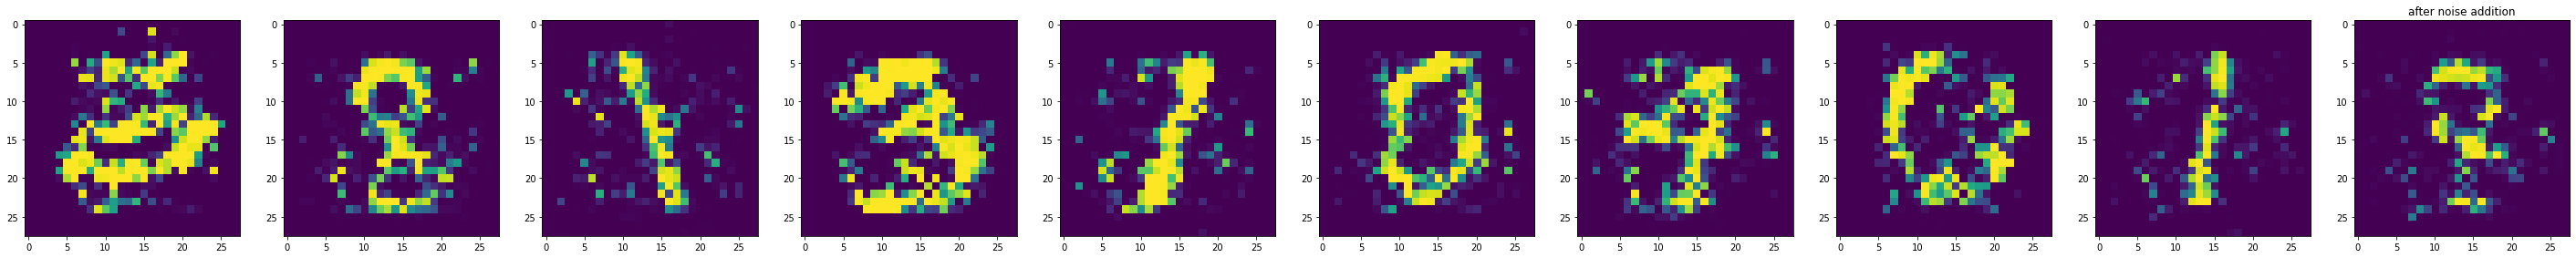

In [114]:
import matplotlib
index=np.random.randint(0,10000,10)
autoencoder.load_weights(checkpoint_filepath)
figure, ax = plt.subplots(1,10)
for ind,title in enumerate(index):
  ax.ravel()[ind].imshow(X_test[title].reshape(28,28))
  plt.title('original')     
  plt.rcParams["figure.figsize"] = (50,50)
plt.show()

figure, ax = plt.subplots(1,10)
for ind,title in enumerate(index):
  decode_image=autoencoder.predict(X_test[title].reshape(1,784))
  decode_image=decode_image.reshape(784,)
  ax.ravel()[ind].imshow(decode_image.reshape(28,28))
  plt.title('decoded')     
  plt.rcParams["figure.figsize"] = (50,50)
plt.show()

# noise to be added
#std=senstivity/epsilon
std=0.1

old_weights = autoencoder.layers[1].get_weights()
# adding gaussian noise in bias of first layer
old_weights[1]=old_weights[1]+np.random.normal(0,std,64)
# adding gaussiann noise in weights of first layer
for i in range(784):
  old_weights[0][i]=old_weights[0][i]+np.random.normal(0,std,64)

old_weights_2=autoencoder.layers[2].get_weights()
# adding gaussian noise in bias of second layer
old_weights_2[1]=old_weights_2[1]+np.random.normal(0,std,784)
# adding gaussiann noise in weights of second layer
for i in range(64):
  old_weights_2[0][i]=old_weights_2[0][i]+np.random.normal(0,std,784)

model1=autoencoder
model1.layers[1].set_weights(old_weights)
model1.layers[2].set_weights(old_weights_2)


figure, ax = plt.subplots(1,10)
for ind,title in enumerate(index):
  decode_image=model1.predict(X_test[title].reshape(1,784))
  decode_image=decode_image.reshape(784,)
  ax.ravel()[ind].imshow(decode_image.reshape(28,28))
  plt.title('after noise addition')     
  plt.rcParams["figure.figsize"] = (50,50)
plt.show()




# **A DNN Model**

In [119]:
truemodel=tf.keras.Sequential([
tf.keras.layers.Dense(512),
tf.keras.layers.Dense(256),
tf.keras.layers.Dense(128),
tf.keras.layers.Dense(64),
tf.keras.layers.Dense(10)
])

checkpoint_filepath = '/tmp/checkpoint1'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    
    save_best_only=True)

truemodel.compile(optimizer=('adam'),loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])
truemodel.fit(X_train,Y_train,epochs=50,validation_data=(X_test,Y_test),callbacks=[model_checkpoint_callback])

Epoch 1/50
1875/1875 [==============================] - 5s 3ms/step - loss: 0.4354 - accuracy: 0.8739 - val_loss: 0.3552 - val_accuracy: 0.8980
Epoch 2/50
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3647 - accuracy: 0.8957 - val_loss: 0.3131 - val_accuracy: 0.9132
Epoch 3/50
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3414 - accuracy: 0.9025 - val_loss: 0.3370 - val_accuracy: 0.9066
Epoch 4/50
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3253 - accuracy: 0.9072 - val_loss: 0.3211 - val_accuracy: 0.9109
Epoch 5/50
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3180 - accuracy: 0.9094 - val_loss: 0.3167 - val_accuracy: 0.9123
Epoch 6/50
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3112 - accuracy: 0.9118 - val_loss: 0.2973 - val_accuracy: 0.9161
Epoch 7/50
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3036 - accuracy: 0.9142 - val_loss: 0.3102 - val_accuracy:

In [120]:
truemodel.load_weights(checkpoint_filepath)
results = truemodel.evaluate(X_test, Y_test, batch_size=128)
print('truemodel')
print("test loss, test acc:", results)


79/79 [==============================] - 0s 3ms/step - loss: 0.2880 - accuracy: 0.9218
truemodel
test loss, test acc: [0.288004070520401, 0.9218000173568726]


# **A DNN Model with Differential Private Dataset**

In [30]:
xtrain_noisy=model1.predict(X_train)
xtest_noisy=model1.predict(X_test)

In [115]:
testmodel=tf.keras.Sequential([
tf.keras.layers.Dense(512),
tf.keras.layers.Dense(256),
tf.keras.layers.Dense(128),
tf.keras.layers.Dense(64),
tf.keras.layers.Dense(10)
])

checkpoint_filepath = '/tmp/checkpoint2'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    
    save_best_only=True)
testmodel.compile(optimizer=('adam'),loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])
testmodel.fit(xtrain_noisy,Y_train,epochs=50,validation_data=(xtest_noisy,Y_test),callbacks=[model_checkpoint_callback])

Epoch 1/50
1875/1875 [==============================] - 5s 3ms/step - loss: 0.4420 - accuracy: 0.8643 - val_loss: 0.3677 - val_accuracy: 0.8858
Epoch 2/50
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3255 - accuracy: 0.9009 - val_loss: 0.2994 - val_accuracy: 0.9131
Epoch 3/50
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2954 - accuracy: 0.9080 - val_loss: 0.2639 - val_accuracy: 0.9218
Epoch 4/50
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2767 - accuracy: 0.9144 - val_loss: 0.2771 - val_accuracy: 0.9170
Epoch 5/50
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2567 - accuracy: 0.9195 - val_loss: 0.2380 - val_accuracy: 0.9290
Epoch 6/50
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2485 - accuracy: 0.9232 - val_loss: 0.2526 - val_accuracy: 0.9240
Epoch 7/50
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2408 - accuracy: 0.9257 - val_loss: 0.2558 - val_accuracy:

In [116]:
testmodel.load_weights(checkpoint_filepath)
results = testmodel.evaluate(xtest_noisy, Y_test, batch_size=128)
print('testmodel')
print("test loss, test acc:", results)

79/79 [==============================] - 0s 2ms/step - loss: 0.2138 - accuracy: 0.9364
testmodel
test loss, test acc: [0.2137981653213501, 0.9363999962806702]


# **Adding Gaussian Noise to Model weights under DP constraints std=0.05**

In [123]:
truemodel.load_weights(checkpoint_filepath)
results = truemodel.evaluate(X_test, Y_test, batch_size=128)
print('truemodel')
print("test loss, test acc:", results)

testmodel.load_weights(checkpoint_filepath)
results = testmodel.evaluate(xtest_noisy, Y_test, batch_size=128)
print('testmodel')
print("test loss, test acc:", results)


# noise to be added
#std=senstivity/epsilon
std=0.05

old_weights = truemodel.layers[0].get_weights()
# adding gaussian noise in bias of first layer
old_weights[1]=old_weights[1]+np.random.normal(0,std,512)
# adding gaussiann noise in weights of first layer
for i in range(784):
  old_weights[0][i]=old_weights[0][i]+np.random.normal(0,std,512)


#############################################################################################
old_weights_2=truemodel.layers[1].get_weights()
# adding gaussian noise in bias of second layer
old_weights_2[1]=old_weights_2[1]+np.random.normal(0,std,256)
# adding gaussiann noise in weights of second layer
for i in range(512):
  old_weights_2[0][i]=old_weights_2[0][i]+np.random.normal(0,std,256)


##############################################################################################
old_weights_3=truemodel.layers[2].get_weights()
# adding gaussian noise in bias of third layer
old_weights_3[1]=old_weights_3[1]+np.random.normal(0,std,128)
# adding gaussiann noise in weights of third layer
for i in range(256):
  old_weights_3[0][i]=old_weights_3[0][i]+np.random.normal(0,std,128)


##############################################################################################
old_weights_4=truemodel.layers[3].get_weights()
# adding gaussian noise in bias of fourth layer
old_weights_4[1]=old_weights_4[1]+np.random.normal(0,std,64)
# adding gaussiann noise in weights of fourth layer
for i in range(128):
  old_weights_4[0][i]=old_weights_4[0][i]+np.random.normal(0,std,64)


###############################################################################################
old_weights_5=truemodel.layers[4].get_weights()
# adding gaussian noise in bias of fifth layer
old_weights_5[1]=old_weights_5[1]+np.random.normal(0,std,10)
# adding gaussiann noise in weights of fifth layer
for i in range(64):
  old_weights_5[0][i]=old_weights_5[0][i]+np.random.normal(0,std,10)

model1=truemodel
model1.layers[0].set_weights(old_weights)
model1.layers[1].set_weights(old_weights_2)
model1.layers[2].set_weights(old_weights_3)
model1.layers[3].set_weights(old_weights_4)
model1.layers[4].set_weights(old_weights_5)
results = model1.evaluate(X_test, Y_test, batch_size=128)
print('model with gaussian noise')
print("test loss, test acc:", results)

79/79 [==============================] - 0s 3ms/step - loss: 0.2880 - accuracy: 0.9218
truemodel
test loss, test acc: [0.288004070520401, 0.9218000173568726]
79/79 [==============================] - 0s 3ms/step - loss: 3.6266 - accuracy: 0.4871
testmodel
test loss, test acc: [3.6265506744384766, 0.4871000051498413]
79/79 [==============================] - 0s 2ms/step - loss: 0.8968 - accuracy: 0.7627
model with gaussian noise
test loss, test acc: [0.8967832326889038, 0.7627000212669373]
